In [2]:
# Azure Connection for the data base.


## issue: Blobs DB does not have an inherent indices system.

In [11]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__
import os
from datetime import datetime
import time
import shutil
import cv2
import numpy as np
from skimage.io import imread, imshow

In [12]:
local_dir = './d1'

if not os.path.exists(local_dir): os.makedirs(local_dir)

In [13]:
# Azure connecting info. 
os.environ['AZURE_STORAGE_CONNECTION_STRING'] = 'DefaultEndpointsProtocol=https;AccountName=blobsdb;AccountKey=tJK43kihAcaeZMjcegWFcyg8tsFmOr9f2Kn8q6NUinVSJW5O3jymYbjaiGBjmx8Ibq5LsBVPcABvYeV+tUCPnQ==;EndpointSuffix=core.windows.net'
connect_str = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
# Create the BlobServiceClient object which will be used to create a container client.
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [14]:
def retrieve_last_k_containers(k):
    
    "function retrieve last k containers from Azure Blobs Storage"

    container_list=[]
    # list containers
    for i,item in enumerate(reversed(list(blob_service_client.list_containers()))):
        print(datetime.fromtimestamp(int(item["name"].split("-")[0])))
        container_list.append(item["name"])
        if i ==k:
            break
    return container_list

In [15]:
container_list=retrieve_last_k_containers(5)

2021-11-29 16:47:34
2021-11-29 16:30:35
2021-11-29 16:13:36
2021-11-29 15:56:38
2021-11-29 15:39:39
2021-11-29 15:22:40


# Download files - blobs

In [29]:
def dl_blobs_to_local(container_list):
    for container in container_list:
        dir_name = local_dir + "/" + container
        os.makedirs(dir_name)
        container_client = blob_service_client.get_container_client(container)
        for blob in container_client.list_blobs():
            save_blob(blob.name,dir_name,container_client)
            
            
def save_blob(blob_name,dir_name,container_client):
    
    "function downloads and saves one blob"
    
    with open(dir_name+"/"+ str(blob_name), "wb") as my_blob:
        blob_client = container_client.get_blob_client(blob_name) # Instantiate a new BlobClient
        download_stream = blob_client.download_blob()
        my_blob.write(download_stream.readall())

In [30]:
shutil.rmtree(local_dir) #delete directory


In [31]:
dl_blobs_to_local(container_list) # download

In [128]:
def mask_images(img_path, erode_func, output_lib, params, output_ext=".jpg"):
    """:param img_path: string, path to the image.
       :param erode_func: function, masking function.
       :param output_lib: string, path to output directory.
       :param output_ext: string, type of output image, default jpg.
       :param params: dictionary mask- parameters.

       :returns np.arrays of g_img, mask_g and img

       """

    # set cropping and masking parameters:
    hlc, hrc, vlc, vuc = params["hlc"], params["hrc"], params["vlc"], params["vuc"]
    n, n_iter = params["n"], params["n_iter"]

    # extract img name:
    img_name = os.path.splitext(Path(img_path).name)[0]

    # output name
    g_img_path = output_lib + '/' + 'gr_' + img_name + output_ext  # output path to g_img

    img = cv2.imread(img_path)[vlc:vuc, hlc:hrc]  # cv2 read & crop
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # convert to hsv
    mask = cv2.inRange(hsv, (35, 25, 25), (80, 255, 255))  # mask by slicing the green spectrum
    # mask = cv2.inRange(hsv, (0, 42, 0), (179, 255, 255)) # everything except white

    # apply the masking:
    imask = mask > 0
    g_img = np.zeros_like(img, np.uint8)
    mask_g = np.zeros_like(img, np.uint8)

    # make white background
    g_img.fill(255)
    g_img[imask] = img[imask]
    mask_g[~imask] = img[~ imask]
    mask_g[mask_g != 0] = 255

    # erosion
    g_img, mask, img = erode_func(img, mask_g, n, n_iter)

    # save to directory
    cv2.imwrite(g_img_path, g_img)

    return g_img, mask, img

In [179]:
img1 = "./d1/1638192703-632552/52img0-88.jpg"
img2 = "./d1/1638192703-632552/52img1-41.jpg"
img3 = "./d1/1638192703-632552/52img1-87.jpg"

In [181]:
im1 = cv2.imread(img1)
im2 = cv2.imread(img2)
im3 = cv2.imread(img3)

In [182]:
image1 = imread(img1)
image2 = imread(img2)
image3 = imread(img3)

In [183]:
image1= np.int32(im1)

image2= np.int32(im2)

image3= np.int32(im3)

image12 = image1 - image2
image32 = image3 - image2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


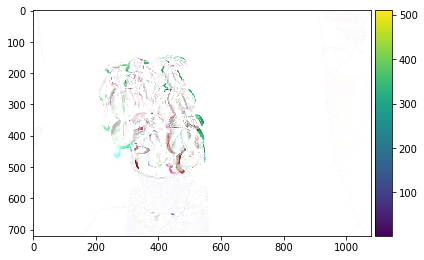

In [184]:
imshow(255-image12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


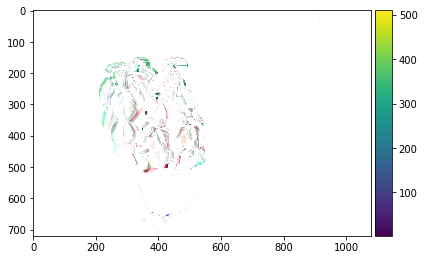

In [185]:
imshow(255-image32)

In [1]:
cv2.imshow("Input", cv2.subtract(im1,im2))

NameError: name 'cv2' is not defined

# COLMAP